# SECTION 0: IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
import shap

C:\Users\lucar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt import space
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform, randint, uniform

In [3]:
from pyforest import*
lazy_imports()

['from sklearn.ensemble import GradientBoostingRegressor',
 'from PIL import Image',
 'import tensorflow as tf',
 'import spacy',
 'from sklearn.feature_extraction.text import CountVectorizer',
 'import lightgbm as lgb',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'import datetime as dt',
 'import altair as alt',
 'import fbprophet',
 'import matplotlib.pyplot as plt',
 'import numpy as np',
 'import plotly as py',
 'from openpyxl import load_workbook',
 'from sklearn.preprocessing import LabelEncoder',
 'from sklearn.preprocessing import OneHotEncoder',
 'from sklearn.preprocessing import PolynomialFeatures',
 'from sklearn.decomposition import PCA',
 'import imutils',
 'import tqdm',
 'from sklearn.cluster import KMeans',
 'import os',
 'from scipy import stats',
 'import sklearn',
 'from sklearn.manifold import TSNE',
 'import skimage',
 'import sys',
 'from sklearn.ensemble import RandomForestClassifier',
 'from fbprophet import Prophet',
 'import matplotlib as mpl

# SECTION 1: DATA LOADING

In [6]:
df = pd.read_csv("C:/Users/lucar/Documents/My Documents/03 Uni/02 Bath/02 AIML/Concrete Project/Code/Concrete_Data_1.csv")
df.head()

<IPython.core.display.Javascript object>

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [7]:
df = df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':'cement',
                        'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':'slag',
                        'Fly Ash (component 3)(kg in a m^3 mixture)':'ash',
                        'Water (component 4)(kg in a m^3 mixture)':'water',
                        "Superplasticizer (component 5)(kg in a m^3 mixture)":'superplastic',
                        'Coarse Aggregate (component 6)(kg in a m^3 mixture)':'coarseagg',
                        'Fine Aggregate (component 7)(kg in a m^3 mixture)':'fineagg',
                        'Age (day)':'age',
                        'Concrete compressive strength(MPa, megapascals)':'strength'
})
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarseagg', 'fineagg', 'age', 'strength']
df.head()

,cement,slag,ash,water,superplasticizer,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [8]:
df.dtypes

cement              float64
slag                float64
ash                 float64
water               float64
superplasticizer    float64
coarseagg           float64
fineagg             float64
age                   int64
strength            float64
dtype: object

In [9]:
#checking for missing values
df.isnull().sum()

cement              0
slag                0
ash                 0
water               0
superplasticizer    0
coarseagg           0
fineagg             0
age                 0
strength            0
dtype: int64

In [10]:
stats = df.describe().T
stats['mode'] = df.mode().iloc[0]

stats = stats.round(2)
stats = stats[['count', 'mean', 'std', 'min', '50%', 'max', 'mode']]
stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Median', 'Max', 'Mode']
stats.index.name = 'Feature'

print(stats.to_string())


                   Count    Mean  Std Dev     Min  Median     Max   Mode
Feature                                                                 
cement            1030.0  281.17   104.51  102.00  272.90   540.0  362.6
slag              1030.0   73.90    86.28    0.00   22.00   359.4    0.0
ash               1030.0   54.19    64.00    0.00    0.00   200.1    0.0
water             1030.0  181.57    21.35  121.80  185.00   247.0  192.0
superplasticizer  1030.0    6.20     5.97    0.00    6.40    32.2    0.0
coarseagg         1030.0  972.92    77.75  801.00  968.00  1145.0  932.0
fineagg           1030.0  773.58    80.18  594.00  779.50   992.6  594.0
age               1030.0   45.66    63.17    1.00   28.00   365.0   28.0
strength          1030.0   35.82    16.71    2.33   34.44    82.6   33.4


In [11]:
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Number of duplicate rows: 25
     cement   slag  ash  water  superplasticizer  coarseagg  fineagg  age  \
77    425.0  106.3  0.0  153.5              16.5      852.1    887.1    3   
80    425.0  106.3  0.0  153.5              16.5      852.1    887.1    3   
86    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
88    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
91    362.6  189.0  0.0  164.9              11.6      944.7    755.8    3   
100   425.0  106.3  0.0  153.5              16.5      852.1    887.1    7   
103   425.0  106.3  0.0  153.5              16.5      852.1    887.1    7   
109   362.6  189.0  0.0  164.9              11.6      944.7    755.8    7   
111   362.6  189.0  0.0  164.9              11.6      944.7    755.8    7   
123   425.0  106.3  0.0  153.5              16.5      852.1    887.1   28   
126   425.0  106.3  0.0  153.5              16.5      852.1    887.1   28   
132   362.6  189.0  0.0  164.9              11.

# SECTION 2: UNIVARIATE EDA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cement'], ax=ax2[0][0], kde=True)


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['slag'],ax=ax2[0][1])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['ash'],ax=ax2[0][2])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['water'],ax=ax2[1][0])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['superplasticizer'],ax=ax2[1][1])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['coarseagg'],ax=ax2[1][2])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['fineagg'],ax=ax2[2][0])


<IPython.core.display.Javascript object>

C:\Users\lucar\AppData\Local\Temp\ipykernel_192996\1273996386.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'],ax=ax2[2][1])


<IPython.core.display.Javascript object>

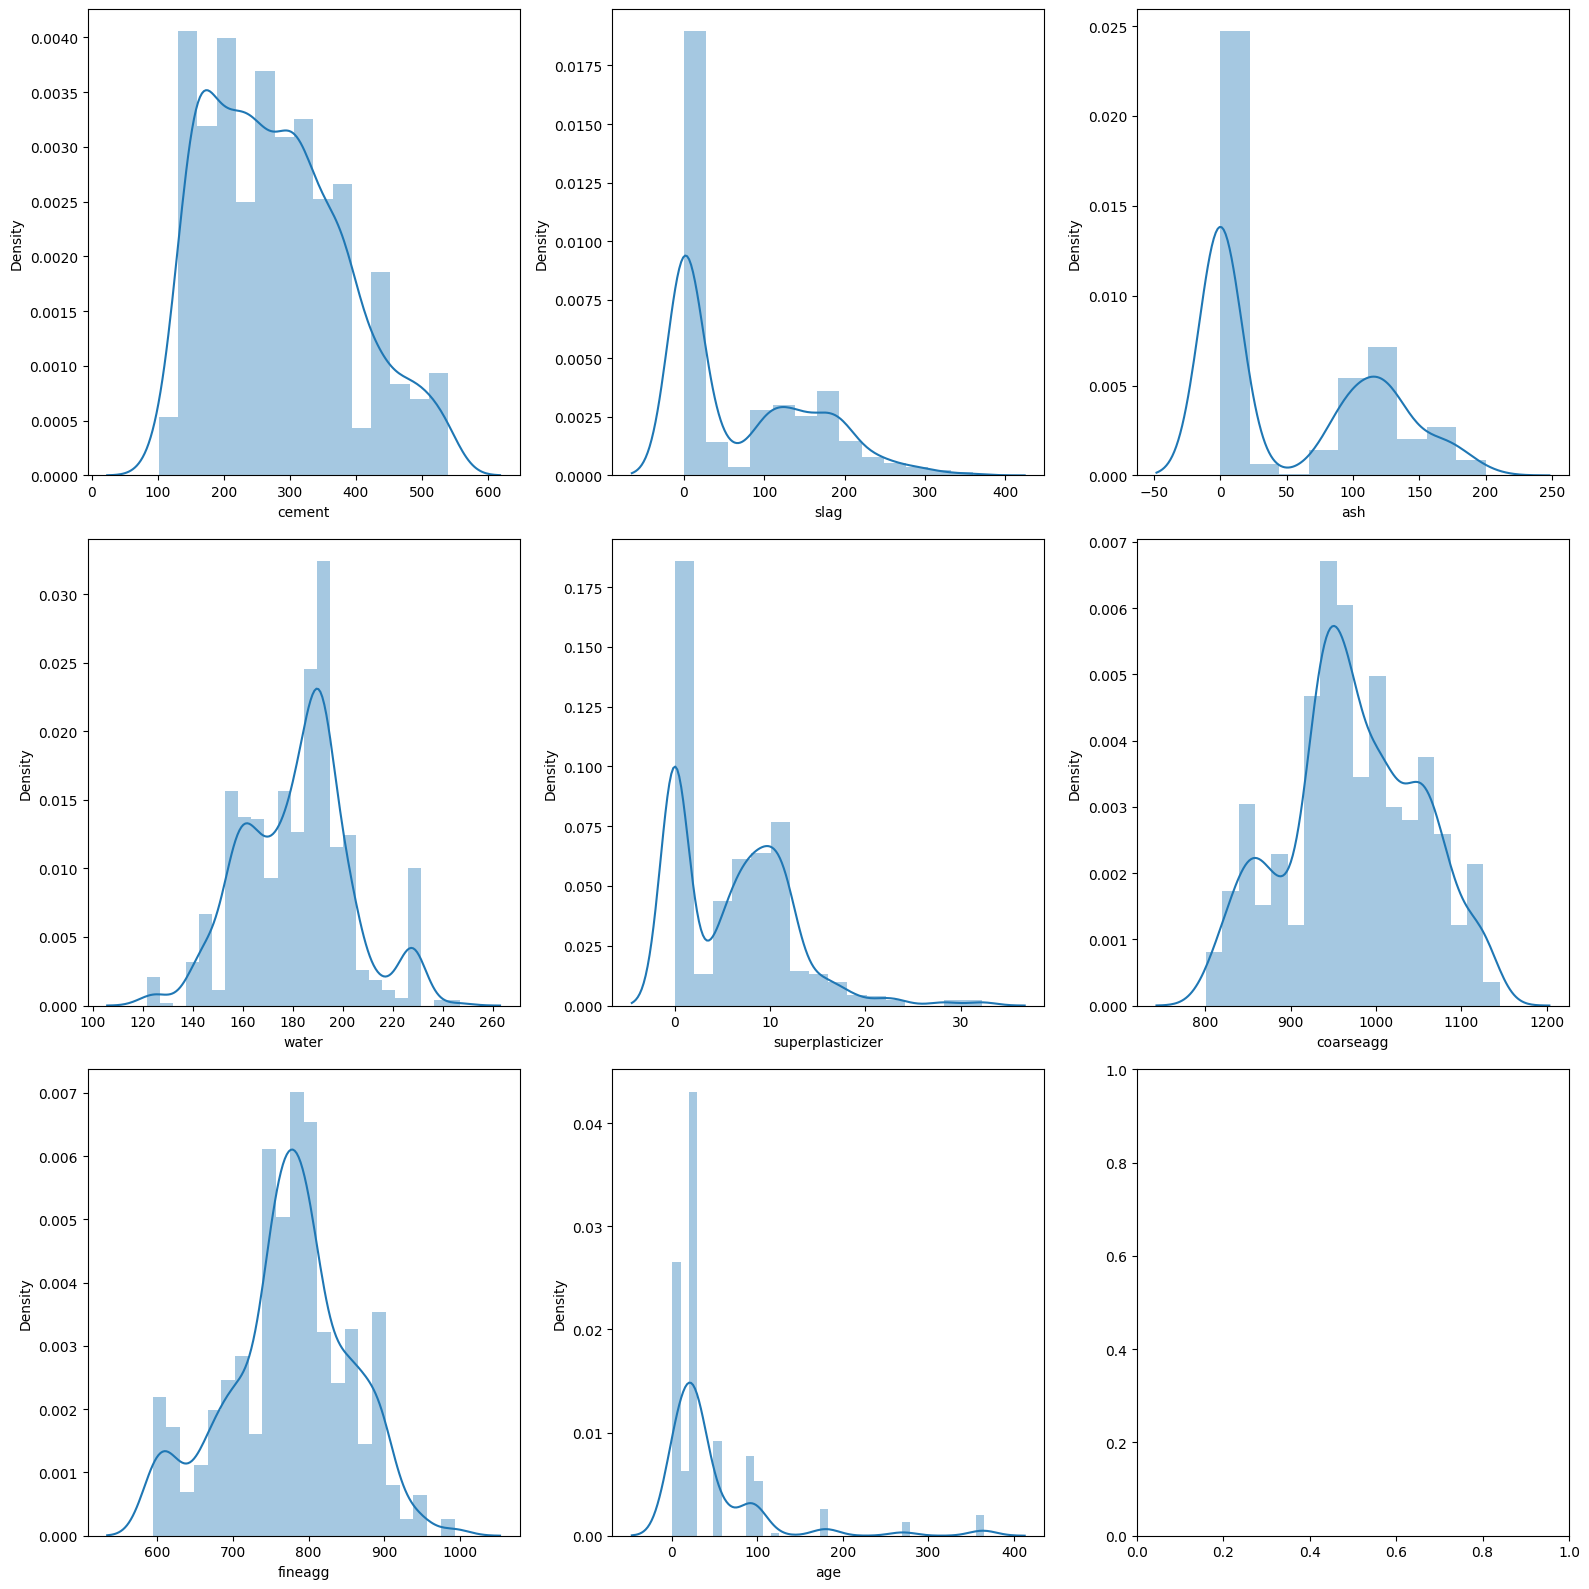

In [12]:
fig,ax2 = plt.subplots(3,3,figsize=(16,16))
sns.distplot(df['cement'], ax=ax2[0][0], kde=True)
sns.distplot(df['slag'],ax=ax2[0][1])
sns.distplot(df['ash'],ax=ax2[0][2])
sns.distplot(df['water'],ax=ax2[1][0])
sns.distplot(df['superplasticizer'],ax=ax2[1][1])
sns.distplot(df['coarseagg'],ax=ax2[1][2])
sns.distplot(df['fineagg'],ax=ax2[2][0])
sns.distplot(df['age'],ax=ax2[2][1])
plt.tight_layout()

# SECTION 3: OUTLIER DETECTION

In [13]:
def detect_outliers_zscore(df, features, threshold=5, method='zscore'):
    outlier_mask = pd.Series(True, index=df.index)
    outlier_summary = {}
    
    for feature in features:
        if method == 'zscore':
            z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
            outlier_count = (z_scores > threshold).sum()
        
        outlier_summary[feature] = outlier_count
        outlier_mask = outlier_mask & (z_scores <= threshold)
    
    return outlier_mask, outlier_summary

raw_features = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarseagg', 'fineagg', 'age', 'strength']

outlier_mask, outlier_summary = detect_outliers_zscore(df, raw_features, threshold=5, method='zscore')

print("OUTLIER DETECTION SUMMARY (Z-score method, threshold = 5 SD)")
for feature, count in outlier_summary.items():
    pct = count / len(df) * 100
    print(f"  {feature:25s}: {count:3d} outliers ({pct:5.2f}%)")

print(f"\n{"Total samples with outliers":25s}: {(~outlier_mask).sum()}")
print(f"{"Clean samples":25s}: {outlier_mask.sum()} ({outlier_mask.sum()/len(df)*100:.2f}%)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

OUTLIER DETECTION SUMMARY (Z-score method, threshold = 5 SD)
  cement                   :   0 outliers ( 0.00%)
  slag                     :   0 outliers ( 0.00%)
  ash                      :   0 outliers ( 0.00%)
  water                    :   0 outliers ( 0.00%)
  superplasticizer         :   0 outliers ( 0.00%)
  coarseagg                :   0 outliers ( 0.00%)
  fineagg                  :   0 outliers ( 0.00%)
  age                      :  14 outliers ( 1.36%)
  strength                 :   0 outliers ( 0.00%)

Total samples with outliers: 14
Clean samples            : 1016 (98.64%)


# SECTION 4: BOXPLOTS

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

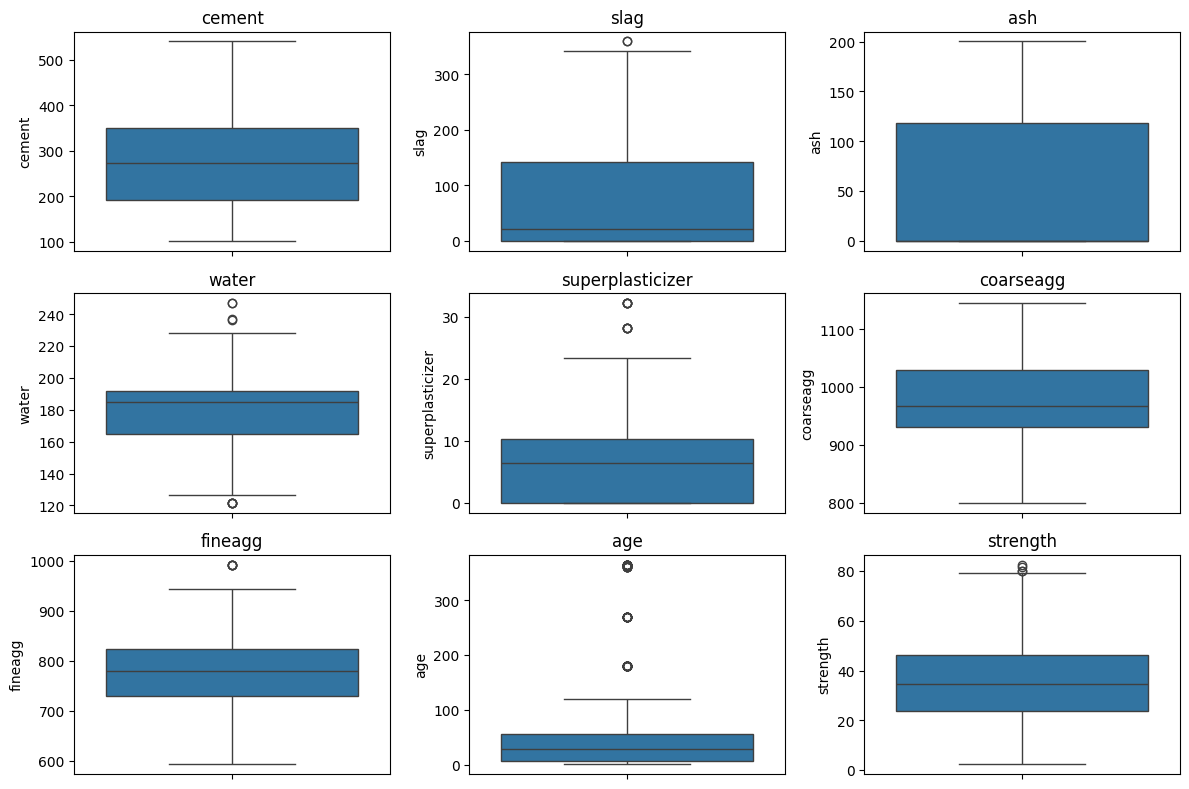

In [14]:
outlier_mask, outlier_summary = detect_outliers_zscore(df, raw_features, threshold=5, method='zscore')

plt.figure(figsize=(12, 8))
for i, col in enumerate(raw_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# SECTION 5: PEARSON CORRELATIONS & EDA MULTIVARIATE ANALYSIS

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

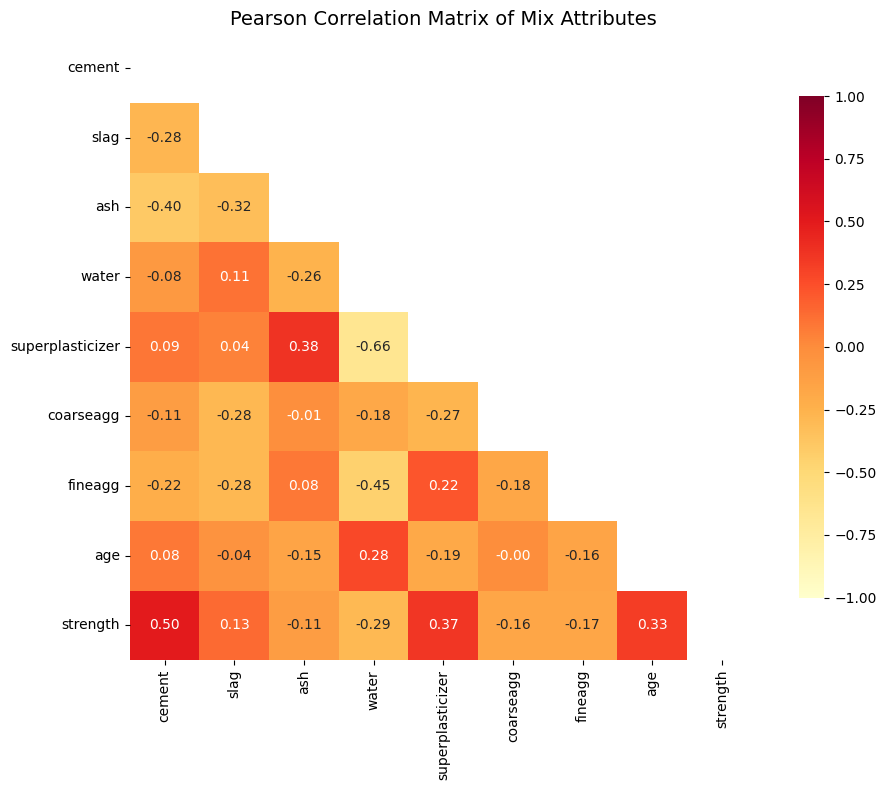

In [15]:
corr = df[raw_features].corr(method='pearson')

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='YlOrRd', square=True,cbar_kws={"shrink": 0.8})

plt.title('Pearson Correlation Matrix of Mix Attributes', fontsize=14)
plt.tight_layout()
plt.savefig('pearson_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# SECTION 6: FEATURE ENGINEERING

In [16]:
df_engineered = df.copy()

#New Ratios between features
df_engineered['water_cement_ratio'] = df['water'] / df['cement']
df_engineered['binder_total'] = df['cement'] + df['slag'] + df['ash']

#Age binning
bins = [0, 1, 3, 7, 14, 28, 56, 90, 180, 365]
labels = ['very_early', 'very_early2', 'early', 'early2', 'week1', 'week2', 'month3', 'month6', 'year1']
df_engineered['age_category'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
df_engineered['age_bin'] = pd.cut(df['age'], bins=bins, include_lowest=True).cat.codes
#Age indicators
df_engineered['is_very_early'] = (df['age'] <= 3).astype(int)
df_engineered['is_early_cure'] = ((df['age'] > 3) & (df['age'] <= 7)).astype(int)
df_engineered['is_7day'] = (df['age'] == 7).astype(int)
df_engineered['is_28day'] = (df['age'] == 28).astype(int)
df_engineered['is_mature'] = (df['age'] >= 28).astype(int)
df_engineered['is_very_mature'] = (df['age'] >= 90).astype(int)

#Binary Indicators for zero-inflated features
df_engineered['has_slag'] = (df['slag'] > 0).astype(int)
df_engineered['has_ash'] = (df['ash'] > 0).astype(int)
df_engineered['has_superplasticizer'] = (df['superplasticizer'] > 0).astype(int)

print(df_engineered.head())
print(df_engineered.columns)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   cement   slag  ash  water  superplasticizer  coarseagg  fineagg  age  \
0   540.0    0.0  0.0  162.0               2.5     1040.0    676.0   28   
1   540.0    0.0  0.0  162.0               2.5     1055.0    676.0   28   
2   332.5  142.5  0.0  228.0               0.0      932.0    594.0  270   
3   332.5  142.5  0.0  228.0               0.0      932.0    594.0  365   
4   198.6  132.4  0.0  192.0               0.0      978.4    825.5  360   

   strength  water_cement_ratio  ...  age_bin is_very_early  is_early_cure  \
0     79.99            0.300000  ...        4             0              0   
1     61.89            0.300000  ...        4             0              0   
2     40.27            0.685714  ...        8             0              0   
3     41.05            0.685714  ...        8             0              0   
4     44.30            0.966767  ...        8             0              0   

   is_7day  is_28day  is_mature  is_very_mature  has_slag  has_ash  \
0        0

# SECTION 7: CREATE TWO DATASETS

In [17]:
print("CREATING TWO DATASETS: WITH & WITHOUT OUTLIERS")

# DATASET 1: WITH OUTLIERS (for RF and XGB)
X_with_outliers = df_engineered.drop(columns=['strength', 'age_category', 'age'])
y_with_outliers = df_engineered['strength']

print(f"\nDataset 1 - WITH OUTLIERS (for tree-based models):")
print(f"  Total samples: {len(X_with_outliers)}")
print(f"  Features: {X_with_outliers.shape[1]}")

# DATASET 2: WITHOUT OUTLIERS (for SVR)
df_clean = df_engineered[outlier_mask].copy()
X_without_outliers = df_clean.drop(columns=['strength', 'age_category', 'age'])
y_without_outliers = df_clean['strength']

print(f"\nDataset 2 - WITHOUT OUTLIERS (for SVR):")
print(f"  Clean samples: {len(X_without_outliers)}")
print(f"  Features: {X_without_outliers.shape[1]}")
print(f"  Outliers removed: {len(X_with_outliers) - len(X_without_outliers)}")

CREATING TWO DATASETS: WITH & WITHOUT OUTLIERS

Dataset 1 - WITH OUTLIERS (for tree-based models):
  Total samples: 1030
  Features: 19

Dataset 2 - WITHOUT OUTLIERS (for SVR):
  Clean samples: 1016
  Features: 19
  Outliers removed: 14


# SECTION 8: CREATE TWO-WAY SPLITS, TRAIN/TEST

In [18]:
# DATASET 1: WITH OUTLIERS (for RF and XGB)
print("Dataset 1: TRAIN/TEST SPLIT WITH OUTLIERS (Random Forest & XGBoost)")

# Split 80% 20% 
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_outliers, y_with_outliers, test_size=0.2, random_state=42)

print(f"Train set: {X_train_with.shape[0]} samples (80%)")
print(f"Test set:  {X_test_with.shape[0]} samples (20%)")

# DATASET 2: WITHOUT OUTLIERS (for SVR)
print("\nDataset 2: TRAIN/TEST SPLIT WITH  WITHOUT OUTLIERS (SVR)")

# Split 80% 20%
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_without_outliers, y_without_outliers, test_size=0.2, random_state=42)

print(f"Train set: {X_train_clean.shape[0]} samples (80%)")
print(f"Test set:  {X_test_clean.shape[0]} samples (20%)")

Dataset 1: TRAIN/TEST SPLIT WITH OUTLIERS (Random Forest & XGBoost)


<IPython.core.display.Javascript object>

Train set: 824 samples (80%)
Test set:  206 samples (20%)

Dataset 2: TRAIN/TEST SPLIT WITH  WITHOUT OUTLIERS (SVR)


<IPython.core.display.Javascript object>

Train set: 812 samples (80%)
Test set:  204 samples (20%)


# SECTION 9: RANDOM FOREST

# SECTION 9.1: RF - BAYESIAN OPTIMIZATION 

In [19]:
# Pipeline (No scaler needed for RF)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Define Bayesian search space
search_space_rf_bayes = {
    'rf__n_estimators': Integer(300, 800),
    'rf__max_depth': Integer(5, 25),
    'rf__min_samples_split': Integer(2, 12),
    'rf__min_samples_leaf': Integer(1, 8),
    'rf__max_features': Categorical(['sqrt', 'log2', 0.5, 0.7])
}

# Bayesian Optimization
print("\nPerforming Bayesian Optimization (Random Forest)...")
start_time = time.time()

bayes_search_rf = BayesSearchCV(
    estimator=rf_pipe,
    search_spaces=search_space_rf_bayes,
    n_iter=40,              
    cv=5,                   
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Bayesian Optimization Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {bayes_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {bayes_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {bayes_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {bayes_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {bayes_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_bayes = bayes_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_bayes = best_rf_bayes.predict(X_train_with)
rf_test_pred_bayes = best_rf_bayes.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_bayes = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_bayes))
rf_train_mae_bayes  = mean_absolute_error(y_train_with, rf_train_pred_bayes)
rf_train_r2_bayes   = r2_score(y_train_with, rf_train_pred_bayes)
rf_train_mape_bayes = np.mean(np.abs((y_train_with - rf_train_pred_bayes) / y_train_with)) * 100

# Test
rf_test_rmse_bayes = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_bayes))
rf_test_mae_bayes  = mean_absolute_error(y_test_with, rf_test_pred_bayes)
rf_test_r2_bayes   = r2_score(y_test_with, rf_test_pred_bayes)
rf_test_mape_bayes = np.mean(np.abs((y_test_with - rf_test_pred_bayes) / y_test_with)) * 100

print("Random Forest Bayesian Optimization Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_bayes:.4f} MPa")
print(f"  MAE:  {rf_train_mae_bayes:.4f} MPa")
print(f"  MAPE: {rf_train_mape_bayes:.2f}%")
print(f"  R²:   {rf_train_r2_bayes:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_bayes:.4f} MPa")
print(f"  MAE:  {rf_test_mae_bayes:.4f} MPa")
print(f"  MAPE: {rf_test_mape_bayes:.2f}%")
print(f"  R²:   {rf_test_r2_bayes:.4f}")

<IPython.core.display.Javascript object>


Performing Bayesian Optimization (Random Forest)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Bayesian Optimization Performance

Training Set:
  RMSE: 1.9104 MPa
  MAE:  1.2245 MPa
  MAPE: 4.37%
  R²:   0.9872

Test Set:
  RMSE: 5.0373 MPa
  MAE:  3.5307 MPa
  MAPE: 11.55%
  R²:   0.9015


# SECTION 9.2: RF - GRIDSEARCHCV

In [20]:
# Pipeline (no scaler needed for RF)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Grid search space
search_space_grid_rf = {
    'rf__n_estimators': [300, 500, 800],        
    'rf__max_depth': [5, 10, 15, 20, 25],
    'rf__min_samples_split': [2, 4, 8, 12],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__max_features': ['sqrt', 'log2', 0.5, 0.7]
}

# Grid Search
print("\nPerforming Grid Search (Random Forest)...")
start_time = time.time()

grid_search_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=search_space_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Grid Search Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {grid_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {grid_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {grid_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {grid_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {grid_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_grid = grid_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_grid = best_rf_grid.predict(X_train_with)
rf_test_pred_grid = best_rf_grid.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_grid = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_grid))
rf_train_mae_grid  = mean_absolute_error(y_train_with, rf_train_pred_grid)
rf_train_r2_grid   = r2_score(y_train_with, rf_train_pred_grid)
rf_train_mape_grid = np.mean(np.abs((y_train_with - rf_train_pred_grid) / y_train_with)) * 100

# Test
rf_test_rmse_grid = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_grid))
rf_test_mae_grid  = mean_absolute_error(y_test_with, rf_test_pred_grid)
rf_test_r2_grid   = r2_score(y_test_with, rf_test_pred_grid)
rf_test_mape_grid = np.mean(np.abs((y_test_with - rf_test_pred_grid) / y_test_with)) * 100

print("Random Forest Grid Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_grid:.4f} MPa")
print(f"  MAE:  {rf_train_mae_grid:.4f} MPa")
print(f"  MAPE: {rf_train_mape_grid:.2f}%")
print(f"  R²:   {rf_train_r2_grid:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_grid:.4f} MPa")
print(f"  MAE:  {rf_test_mae_grid:.4f} MPa")
print(f"  MAPE: {rf_test_mape_grid:.2f}%")
print(f"  R²:   {rf_test_r2_grid:.4f}")

<IPython.core.display.Javascript object>


Performing Grid Search (Random Forest)...


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Random Forest - Grid Search Results

Best Parameters Found:
  n_estimators: 500
  max_depth: 20
  min_samples_split: 2
  min_samples_leaf: 1

Best CV R² Score: 0.9156
Search Time: 28.14 minutes

Making predictions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Grid Search Performance

Training Set:
  RMSE: 1.8994 MPa
  MAE:  1.2118 MPa
  MAPE: 4.34%
  R²:   0.9873

Test Set:
  RMSE: 5.0186 MPa
  MAE:  3.5187 MPa
  MAPE: 11.52%
  R²:   0.9023


# SECTION 9.3: RF - RANDOMSEARCHCV

In [21]:
# Pipeline (no scaler needed for RF)
rf_pipe = Pipeline([('rf', RandomForestRegressor(random_state=42, n_jobs=-1))])

# Random search space 
search_space_rf_random= {
    'rf__n_estimators': [300, 500, 800],       
    'rf__max_depth': [5, 10, 15, 20, 25],
    'rf__min_samples_split': [2, 4, 8, 12],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__max_features': ['sqrt', 'log2', 0.5, 0.7]
}

# Random Search
print("\nPerforming Random Search (Random Forest)...")
start_time = time.time()

random_search_rf = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=search_space_rf_random,
    n_iter=40,         
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train_with, y_train_with)
elapsed_time = time.time() - start_time

# Results
print("Random Forest - Random Search Results")
print(f"\nBest Parameters Found:")
print(f"  n_estimators: {random_search_rf.best_params_['rf__n_estimators']}")
print(f"  max_depth: {random_search_rf.best_params_['rf__max_depth']}")
print(f"  min_samples_split: {random_search_rf.best_params_['rf__min_samples_split']}")
print(f"  min_samples_leaf: {random_search_rf.best_params_['rf__min_samples_leaf']}")

print(f"\nBest CV R² Score: {random_search_rf.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_rf_random = random_search_rf.best_estimator_

# Predictions
print("\nMaking predictions...")
rf_train_pred_random = best_rf_random.predict(X_train_with)
rf_test_pred_random = best_rf_random.predict(X_test_with)

# Metrics
# Train
rf_train_rmse_random = np.sqrt(mean_squared_error(y_train_with, rf_train_pred_random))
rf_train_mae_random  = mean_absolute_error(y_train_with, rf_train_pred_random)
rf_train_r2_random   = r2_score(y_train_with, rf_train_pred_random)
rf_train_mape_random = np.mean(np.abs((y_train_with - rf_train_pred_random) / y_train_with)) * 100

# Test
rf_test_rmse_random = np.sqrt(mean_squared_error(y_test_with, rf_test_pred_random))
rf_test_mae_random  = mean_absolute_error(y_test_with, rf_test_pred_random)
rf_test_r2_random   = r2_score(y_test_with, rf_test_pred_random)
rf_test_mape_random = np.mean(np.abs((y_test_with - rf_test_pred_random) / y_test_with)) * 100

print("Random Forest Random Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {rf_train_rmse_random:.4f} MPa")
print(f"  MAE:  {rf_train_mae_random:.4f} MPa")
print(f"  MAPE: {rf_train_mape_random:.2f}%")
print(f"  R²:   {rf_train_r2_random:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {rf_test_rmse_random:.4f} MPa")
print(f"  MAE:  {rf_test_mae_random:.4f} MPa")
print(f"  MAPE: {rf_test_mape_random:.2f}%")
print(f"  R²:   {rf_test_r2_random:.4f}")

<IPython.core.display.Javascript object>


Performing Random Search (Random Forest)...


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Random Forest - Random Search Results

Best Parameters Found:
  n_estimators: 300
  max_depth: 20
  min_samples_split: 2
  min_samples_leaf: 1

Best CV R² Score: 0.9148
Search Time: 1.19 minutes

Making predictions...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Random Forest Random Search Performance

Training Set:
  RMSE: 1.9021 MPa
  MAE:  1.2112 MPa
  MAPE: 4.33%
  R²:   0.9873

Test Set:
  RMSE: 5.0505 MPa
  MAE:  3.5315 MPa
  MAPE: 11.51%
  R²:   0.9010


# SECTION 9.4: RF HYPERPARAMETER TEST COMPARISON

In [22]:
comparison_data_rf = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_rf.best_score_:.4f}",
        f"{grid_search_rf.best_score_:.4f}",
        f"{random_search_rf.best_score_:.4f}"
    ],
    'Train R²': [
        f"{rf_train_r2_bayes:.4f}",
        f"{rf_train_r2_grid:.4f}",
        f"{rf_train_r2_random:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{rf_train_rmse_bayes:.4f}",
        f"{rf_train_rmse_grid:.4f}",
        f"{rf_train_rmse_random:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{rf_train_mae_bayes:.4f}",
        f"{rf_train_mae_grid:.4f}",
        f"{rf_train_mae_random:.4f}"
    ],
    'Train MAPE (%)': [
        f"{rf_train_mape_bayes:.2f}",
        f"{rf_train_mape_grid:.2f}",
        f"{rf_train_mape_random:.2f}"
    ],
    'Test R²': [
        f"{rf_test_r2_bayes:.4f}",
        f"{rf_test_r2_grid:.4f}",
        f"{rf_test_r2_random:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{rf_test_rmse_bayes:.4f}",
        f"{rf_test_rmse_grid:.4f}",
        f"{rf_test_rmse_random:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{rf_test_mae_bayes:.4f}",
        f"{rf_test_mae_grid:.4f}",
        f"{rf_test_mae_random:.4f}"
    ],
    'Test MAPE (%)': [
        f"{rf_test_mape_bayes:.2f}",
        f"{rf_test_mape_grid:.2f}",
        f"{rf_test_mape_random:.2f}"
    ]
}

comp_df_rf = pd.DataFrame(comparison_data_rf)
print(comp_df_rf.to_string(index=False))

<IPython.core.display.Javascript object>

               Method Best CV R² Train R² Train RMSE (MPa) Train MAE (MPa) Train MAPE (%) Test R² Test RMSE (MPa) Test MAE (MPa) Test MAPE (%)
Bayesian Optimization     0.9163   0.9872           1.9104          1.2245           4.37  0.9015          5.0373         3.5307         11.55
          Grid Search     0.9156   0.9873           1.8994          1.2118           4.34  0.9023          5.0186         3.5187         11.52
        Random Search     0.9148   0.9873           1.9021          1.2112           4.33  0.9010          5.0505         3.5315         11.51


# SECTION 10: XGBOOST

# SECTION 10.1: XGBOOST - BAYESIAN OPTIMIZATION 

In [23]:
# Pipeline (no scaler needed for XGB)
xgb_pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror',random_state=42,n_jobs=-1,verbosity=0))])

# Bayesian search space 
search_space_xgb_bayes = {
    'xgb__n_estimators': Integer(300, 900),
    'xgb__max_depth': Integer(2, 5),
    'xgb__learning_rate': Real(0.01, 0.08),
    'xgb__reg_alpha': Real(0.5, 5.0),
    'xgb__reg_lambda': Real(5.0, 50.0),
    'xgb__subsample': Real(0.5, 0.9),       
    'xgb__colsample_bytree': Real(0.5, 0.9) 
}

print("\nPerforming Bayesian Optimization (XGBoost)...")
start_time = time.time()

bayes_search_xgb = BayesSearchCV(
    estimator=xgb_pipe,
    search_spaces=search_space_xgb_bayes,
    n_iter=40,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_bayes = time.time() - start_time

print("XGBoost - Bayesian Optimization Results")
print(f"\nBest Parameters Found (BayesSearchCV):")
for param, value in bayes_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (BayesSearchCV): {bayes_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_bayes:.2f} seconds ({elapsed_time_bayes/60:.2f} minutes)")

# Best model
best_xgb_bayes = bayes_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best BayesSearchCV model...")
xgb_bayes_train_pred = best_xgb_bayes.predict(X_train_with)
xgb_bayes_test_pred  = best_xgb_bayes.predict(X_test_with)

# Metrics
# Train
xgb_bayes_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_bayes_train_pred))
xgb_bayes_train_mae  = mean_absolute_error(y_train_with, xgb_bayes_train_pred)
xgb_bayes_train_r2   = r2_score(y_train_with, xgb_bayes_train_pred)
xgb_bayes_train_mape = np.mean(np.abs((y_train_with - xgb_bayes_train_pred) / y_train_with)) * 100

# Test
xgb_bayes_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_bayes_test_pred))
xgb_bayes_test_mae  = mean_absolute_error(y_test_with, xgb_bayes_test_pred)
xgb_bayes_test_r2   = r2_score(y_test_with, xgb_bayes_test_pred)
xgb_bayes_test_mape = np.mean(np.abs((y_test_with - xgb_bayes_test_pred) / y_test_with)) * 100

print("\nXGBoost Bayesian Optimization Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_bayes_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_bayes_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_bayes_train_mape:.2f}%")
print(f"  R²:   {xgb_bayes_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_bayes_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_bayes_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_bayes_test_mape:.2f}%")
print(f"  R²:   {xgb_bayes_test_r2:.4f}")


Performing Bayesian Optimization (XGBoost)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


XGBoost Bayesian Optimization Performance

Training Set:
  RMSE: 1.9209 MPa
  MAE:  1.2039 MPa
  MAPE: 4.39%
  R²:   0.9870

Test Set:
  RMSE: 4.1241 MPa
  MAE:  2.8580 MPa
  MAPE: 9.11%
  R²:   0.9340


# SECTION 10.2: XGBOOST - GRIDSEARCHCV

In [ ]:
# Pipeline (no scaler needed for XGB)
xgb_pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror',random_state=42,n_jobs=-1,verbosity=0))])

# Grid search space
search_space_grid_xgb = {
    'xgb__n_estimators': [300, 600, 900],
    'xgb__max_depth':    [2, 3, 4, 5],
    'xgb__learning_rate': [0.01, 0.03, 0.05, 0.08],
    'xgb__reg_alpha':    [0.5, 1.0, 2.5, 5.0],
    'xgb__reg_lambda':   [5.0, 10.0, 25.0, 50.0],
}

print("\nPerforming GridSearchCV (XGBoost)...")
start_time = time.time()

grid_search_xgb = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=search_space_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_grid = time.time() - start_time

print("XGBoost - GridSearchCV Results")
print(f"\nBest Parameters Found (GridSearchCV):")
for param, value in grid_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (GridSearchCV): {grid_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_grid:.2f} seconds ({elapsed_time_grid/60:.2f} minutes)")

# Best model
best_xgb_grid = grid_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best GridSearchCV model...")
xgb_grid_train_pred = best_xgb_grid.predict(X_train_with)
xgb_grid_test_pred  = best_xgb_grid.predict(X_test_with)

# Metrics
# Train
xgb_grid_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_grid_train_pred))
xgb_grid_train_mae  = mean_absolute_error(y_train_with, xgb_grid_train_pred)
xgb_grid_train_r2   = r2_score(y_train_with, xgb_grid_train_pred)
xgb_grid_train_mape = np.mean(np.abs((y_train_with - xgb_grid_train_pred) / y_train_with)) * 100

# Test
xgb_grid_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_grid_test_pred))
xgb_grid_test_mae  = mean_absolute_error(y_test_with, xgb_grid_test_pred)
xgb_grid_test_r2   = r2_score(y_test_with, xgb_grid_test_pred)
xgb_grid_test_mape = np.mean(np.abs((y_test_with - xgb_grid_test_pred) / y_test_with)) * 100

print("\nXGBoost GridSearchCV Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_grid_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_grid_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_grid_train_mape:.2f}%")
print(f"  R²:   {xgb_grid_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_grid_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_grid_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_grid_test_mape:.2f}%")
print(f"  R²:   {xgb_grid_test_r2:.4f}")


Performing GridSearchCV (XGBoost)...


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 16384 candidates, totalling 81920 fits


# SECTION 10.3: XGBOOST - RANDOMSEARCHCV

In [ ]:
# Pipeline (no scaler needed for XGB)
xgb_pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror',random_state=42,n_jobs=-1,verbosity=0))])

# Random search space
search_space_xgb_random = {
    'xgb__n_estimators': [300, 600, 900],
    'xgb__max_depth':    [2, 3, 4, 5],
    'xgb__learning_rate': [0.01, 0.03, 0.05, 0.08],
    'xgb__reg_alpha':    [0.5, 1.0, 2.5, 5.0],
    'xgb__reg_lambda':   [5.0, 10.0, 25.0, 50.0],
}

print("\nPerforming RandomizedSearchCV (XGBoost)...")
start_time = time.time()

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=search_space_xgb_random,
    n_iter=40,        
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_xgb.fit(X_train_with, y_train_with)
elapsed_time_rand = time.time() - start_time

print("XGBoost - RandomizedSearchCV Results")
print(f"\nBest Parameters Found (RandomizedSearchCV):")
for param, value in random_search_xgb.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\nBest CV R² Score (RandomizedSearchCV): {random_search_xgb.best_score_:.4f}")
print(f"Search Time: {elapsed_time_rand:.2f} seconds ({elapsed_time_rand/60:.2f} minutes)")

# Best model
best_xgb_random = random_search_xgb.best_estimator_

# Predictions
print("\nMaking predictions with best RandomizedSearchCV model...")
xgb_random_train_pred = best_xgb_random.predict(X_train_with)
xgb_random_test_pred  = best_xgb_random.predict(X_test_with)

# Metrics
# Train
xgb_random_train_rmse = np.sqrt(mean_squared_error(y_train_with, xgb_random_train_pred))
xgb_random_train_mae  = mean_absolute_error(y_train_with, xgb_random_train_pred)
xgb_random_train_r2   = r2_score(y_train_with, xgb_random_train_pred)
xgb_random_train_mape = np.mean(np.abs((y_train_with - xgb_random_train_pred) / y_train_with)) * 100

# Test
xgb_random_test_rmse = np.sqrt(mean_squared_error(y_test_with, xgb_random_test_pred))
xgb_random_test_mae  = mean_absolute_error(y_test_with, xgb_random_test_pred)
xgb_random_test_r2   = r2_score(y_test_with, xgb_random_test_pred)
xgb_random_test_mape = np.mean(np.abs((y_test_with - xgb_random_test_pred) / y_test_with)) * 100

print("\nXGBoost RandomizedSearchCV Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {xgb_random_train_rmse:.4f} MPa")
print(f"  MAE:  {xgb_random_train_mae:.4f} MPa")
print(f"  MAPE: {xgb_random_train_mape:.2f}%")
print(f"  R²:   {xgb_random_train_r2:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {xgb_random_test_rmse:.4f} MPa")
print(f"  MAE:  {xgb_random_test_mae:.4f} MPa")
print(f"  MAPE: {xgb_random_test_mape:.2f}%")
print(f"  R²:   {xgb_random_test_r2:.4f}")

# SECTION 10.4: XGBOOST HYPERPARAMETER TEST COMPARISON

In [ ]:
comparison_data_xgb = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_xgb.best_score_:.4f}",
        f"{grid_search_xgb.best_score_:.4f}",
        f"{random_search_xgb.best_score_:.4f}"
    ],
    'Train R²': [
        f"{xgb_bayes_train_r2:.4f}",
        f"{xgb_grid_train_r2:.4f}",
        f"{xgb_random_train_r2:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{xgb_bayes_train_rmse:.4f}",
        f"{xgb_grid_train_rmse:.4f}",
        f"{xgb_random_train_rmse:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{xgb_bayes_train_mae:.4f}",
        f"{xgb_grid_train_mae:.4f}",
        f"{xgb_random_train_mae:.4f}"
    ],
    'Train MAPE (%)': [
        f"{xgb_bayes_train_mape:.2f}",
        f"{xgb_grid_train_mape:.2f}",
        f"{xgb_random_train_mape:.2f}"
    ],
    'Test R²': [
        f"{xgb_bayes_test_r2:.4f}",
        f"{xgb_grid_test_r2:.4f}",
        f"{xgb_random_test_r2:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{xgb_bayes_test_rmse:.4f}",
        f"{xgb_grid_test_rmse:.4f}",
        f"{xgb_random_test_rmse:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{xgb_bayes_test_mae:.4f}",
        f"{xgb_grid_test_mae:.4f}",
        f"{xgb_random_test_mae:.4f}"
    ],
    'Test MAPE (%)': [
        f"{xgb_bayes_test_mape:.2f}",
        f"{xgb_grid_test_mape:.2f}",
        f"{xgb_random_test_mape:.2f}"
    ]
}

comp_df_xgb = pd.DataFrame(comparison_data_xgb)
print(comp_df_xgb.to_string(index=False))


# SECTION 11: SVR

# SECTION 11.1: SVR - BAYESIAN OPTIMIZATION

In [ ]:
# Pipeline to prevent leakage
svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

# Define Bayesian search space
search_space_svr_bayes = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3] 
}

# Bayesian Optimization
print("\nPerforming Bayesian Optimization...")
start_time = time.time()

bayes_search_svr = BayesSearchCV(
    estimator=svr_pipe,
    search_spaces=search_space_svr_bayes,
    n_iter=50,          
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search_svr.fit(X_train_clean, y_train_clean)
elapsed_time = time.time() - start_time

# Results
print("SVR - Bayesian Optimization Results")
print(f"\nBest Parameters Found:")
print(f"  C: {bayes_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {bayes_search_svr.best_params_['svr__gamma']:.6f}")
print(f"  epsilon: {bayes_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {bayes_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {bayes_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {bayes_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_svr_bayes = bayes_search_svr.best_estimator_

# Predictions
print("\nMaking predictions...")
svr_train_pred_bayes = best_svr_bayes.predict(X_train_clean)
svr_test_pred_bayes = best_svr_bayes.predict(X_test_clean)

# Metrics
# Train
svr_train_rmse_bayes = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_bayes))
svr_train_mae_bayes  = mean_absolute_error(y_train_clean, svr_train_pred_bayes)
svr_train_r2_bayes   = r2_score(y_train_clean, svr_train_pred_bayes)
svr_train_mape_bayes = np.mean(np.abs((y_train_clean - svr_train_pred_bayes) / y_train_clean)) * 100

# Test
svr_test_rmse_bayes = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_bayes))
svr_test_mae_bayes  = mean_absolute_error(y_test_clean, svr_test_pred_bayes)
svr_test_r2_bayes   = r2_score(y_test_clean, svr_test_pred_bayes)
svr_test_mape_bayes = np.mean(np.abs((y_test_clean - svr_test_pred_bayes) / y_test_clean)) * 100

print("SVR Bayesian Optimization Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_bayes:.4f} MPa")
print(f"  MAE:  {svr_train_mae_bayes:.4f} MPa")
print(f"  MAPE: {svr_train_mape_bayes:.2f}%")
print(f"  R²:   {svr_train_r2_bayes:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_bayes:.4f} MPa")
print(f"  MAE:  {svr_test_mae_bayes:.4f} MPa")
print(f"  MAPE: {svr_test_mape_bayes:.2f}%")
print(f"  R²:   {svr_test_r2_bayes:.4f}")

# SECTION 11.2: SVR - GRIDSEARCH

In [ ]:
# Pipeline to prevent leakage
svr_pipe = Pipeline([('scaler', StandardScaler()),('svr', SVR())])

# Define search space 
search_space_svr_grid = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3] 
}

# Grid Search
print("\nPerforming Grid Search...")
start_time = time.time()

grid_search_svr = GridSearchCV(
    estimator=svr_pipe,
    param_grid=search_space_svr_grid,
    cv=5,                   
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_svr.fit(X_train_clean, y_train_clean)

elapsed_time = time.time() - start_time

# Print results
print("SVR - Grid Search Results")
print(f"\nBest Parameters Found:")
print(f"  C: {grid_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {grid_search_svr.best_params_['svr__gamma']}")
print(f"  epsilon: {grid_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {grid_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {grid_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {grid_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Get best model
best_svr_grid = grid_search_svr.best_estimator_

# Make predictions
print("\nMaking predictions...")
svr_train_pred_grid = best_svr_grid.predict(X_train_clean)
svr_test_pred_grid = best_svr_grid.predict(X_test_clean)

svr_train_rmse_grid = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_grid))
svr_train_mae_grid = mean_absolute_error(y_train_clean, svr_train_pred_grid)
svr_train_r2_grid = r2_score(y_train_clean, svr_train_pred_grid)
svr_train_mape_grid = np.mean(np.abs((y_train_clean - svr_train_pred_grid) / y_train_clean)) * 100

svr_test_rmse_grid = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_grid))
svr_test_mae_grid = mean_absolute_error(y_test_clean, svr_test_pred_grid)
svr_test_r2_grid = r2_score(y_test_clean, svr_test_pred_grid)
svr_test_mape_grid = np.mean(np.abs((y_test_clean - svr_test_pred_grid) / y_test_clean)) * 100

print("SVR Grid Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_grid:.4f} MPa")
print(f"  MAE:  {svr_train_mae_grid:.4f} MPa")
print(f"  MAPE: {svr_train_mape_grid:.2f}%")
print(f"  R²:   {svr_train_r2_grid:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_grid:.4f} MPa")
print(f"  MAE:  {svr_test_mae_grid:.4f} MPa")
print(f"  MAPE: {svr_test_mape_grid:.2f}%")
print(f"  R²:   {svr_test_r2_grid:.4f}")

# SECTION 11.3: SVR RANDOMSEARCHCV 

In [ ]:
# Pipeline to prevent leakage
svr_pipe = Pipeline([('scaler', StandardScaler()),('svr', SVR())])

# Define search space 
search_space_svr_random = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__C': [10, 50, 100, 200, 300, 500],
    'svr__gamma': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1],
    'svr__epsilon': [1.0, 2.0, 3.0, 4.0],
    'svr__degree': [2, 3] 
}

# Random Search
print("\nPerforming Random Search...")
start_time = time.time()

random_search_svr = RandomizedSearchCV(
    estimator=svr_pipe,
    param_distributions=search_space_svr_random,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_svr.fit(X_train_clean, y_train_clean)
elapsed_time = time.time() - start_time

# Results
print("SVR - Random Search Results")
print(f"\nBest Parameters Found:")
print(f"  C: {random_search_svr.best_params_['svr__C']:.4f}")
print(f"  gamma: {random_search_svr.best_params_['svr__gamma']:.6f}")
print(f"  epsilon: {random_search_svr.best_params_['svr__epsilon']:.4f}")
print(f"  kernel: {random_search_svr.best_params_['svr__kernel']}")
print(f"  degree: {random_search_svr.best_params_['svr__degree']}")

print(f"\nBest CV R² Score: {random_search_svr.best_score_:.4f}")
print(f"Search Time: {elapsed_time/60:.2f} minutes")

# Best model
best_svr_random = random_search_svr.best_estimator_

# Predictions
print("\nMaking predictions...")
svr_train_pred_random = best_svr_random.predict(X_train_clean)
svr_test_pred_random = best_svr_random.predict(X_test_clean)

# Metrics
# Train
svr_train_rmse_random = np.sqrt(mean_squared_error(y_train_clean, svr_train_pred_random))
svr_train_mae_random  = mean_absolute_error(y_train_clean, svr_train_pred_random)
svr_train_r2_random   = r2_score(y_train_clean, svr_train_pred_random)
svr_train_mape_random = np.mean(np.abs((y_train_clean - svr_train_pred_random) / y_train_clean)) * 100

# Test
svr_test_rmse_random = np.sqrt(mean_squared_error(y_test_clean, svr_test_pred_random))
svr_test_mae_random  = mean_absolute_error(y_test_clean, svr_test_pred_random)
svr_test_r2_random   = r2_score(y_test_clean, svr_test_pred_random)
svr_test_mape_random = np.mean(np.abs((y_test_clean - svr_test_pred_random) / y_test_clean)) * 100

print("SVR Random Search Performance")
print(f"\nTraining Set:")
print(f"  RMSE: {svr_train_rmse_random:.4f} MPa")
print(f"  MAE:  {svr_train_mae_random:.4f} MPa")
print(f"  MAPE: {svr_train_mape_random:.2f}%")
print(f"  R²:   {svr_train_r2_random:.4f}")

print(f"\nTest Set:")
print(f"  RMSE: {svr_test_rmse_random:.4f} MPa")
print(f"  MAE:  {svr_test_mae_random:.4f} MPa")
print(f"  MAPE: {svr_test_mape_random:.2f}%")
print(f"  R²:   {svr_test_r2_random:.4f}")

# SECTION 11.4: SVR HYPERPARAMETER TEST COMPARISON

In [ ]:
comparison_data_svr = {
    'Method': ['Bayesian Optimization', 'Grid Search', 'Random Search'],
    'Best CV R²': [
        f"{bayes_search_svr.best_score_:.4f}",
        f"{grid_search_svr.best_score_:.4f}",
        f"{random_search_svr.best_score_:.4f}"
    ],
    'Train R²': [
        f"{svr_train_r2_bayes:.4f}",
        f"{svr_train_r2_grid:.4f}",
        f"{svr_train_r2_random:.4f}"
    ],
    'Train RMSE (MPa)': [
        f"{svr_train_rmse_bayes:.4f}",
        f"{svr_train_rmse_grid:.4f}",
        f"{svr_train_rmse_random:.4f}"
    ],
    'Train MAE (MPa)': [
        f"{svr_train_mae_bayes:.4f}",
        f"{svr_train_mae_grid:.4f}",
        f"{svr_train_mae_random:.4f}"
    ],
    'Train MAPE (%)': [
        f"{svr_train_mape_bayes:.2f}",
        f"{svr_train_mape_grid:.2f}",
        f"{svr_train_mape_random:.2f}"
    ],
    'Test R²': [
        f"{svr_test_r2_bayes:.4f}",
        f"{svr_test_r2_grid:.4f}",
        f"{svr_test_r2_random:.4f}"
    ],
    'Test RMSE (MPa)': [
        f"{svr_test_rmse_bayes:.4f}",
        f"{svr_test_rmse_grid:.4f}",
        f"{svr_test_rmse_random:.4f}"
    ],
    'Test MAE (MPa)': [
        f"{svr_test_mae_bayes:.4f}",
        f"{svr_test_mae_grid:.4f}",
        f"{svr_test_mae_random:.4f}"
    ],
    'Test MAPE (%)': [
        f"{svr_test_mape_bayes:.2f}",
        f"{svr_test_mape_grid:.2f}",
        f"{svr_test_mape_random:.2f}"
    ]
}

comp_df_svr = pd.DataFrame(comparison_data_svr)
print(comp_df_svr.to_string(index=False))

# SECTION 12: OVERALL COMPARISON OF HYPERPARAMTER TUNING BETWEEN MODELS

In [ ]:
comp_df_rf_labeled  = comp_df_rf.copy()
comp_df_xgb_labeled = comp_df_xgb.copy()
comp_df_svr_labeled = comp_df_svr.copy()

comp_df_rf_labeled.insert(0, 'Model', 'Random Forest')
comp_df_xgb_labeled.insert(0, 'Model', 'XGBoost')
comp_df_svr_labeled.insert(0, 'Model', 'SVR')

# Combine into one large table
comp_df_all = pd.concat([comp_df_rf_labeled, comp_df_xgb_labeled, comp_df_svr_labeled],axis=0,ignore_index=True)

print(comp_df_all.to_string(index=False))

# SECTION 13: OVERALL COMPARISON OF HYPERPARAMTER TUNING BETWEEN MODELS

In [ ]:
def create_prediction_scatter_plot(y_true_train, y_pred_train, y_true_test, y_pred_test, model_name, filename):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Calculate axis limits
    max_val = max(max(y_true_train), max(y_pred_train), 
                  max(y_true_test), max(y_pred_test))
    min_val = min(min(y_true_train), min(y_pred_train), 
                  min(y_true_test), min(y_pred_test))
    buffer = (max_val - min_val) * 0.05
    xylim_min = min_val - buffer
    xylim_max = max_val + buffer
    
    # Training Set
    r2_train = r2_score(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    
    ax1.scatter(y_true_train, y_pred_train, alpha=0.6, s=40, c='#1f77b4', edgecolors='k', linewidth=0.5, label=f'Training (n={len(y_true_train)})')
    ax1.plot([xylim_min, xylim_max], [xylim_min, xylim_max], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Add metrics box
    train_text = f'R² = {r2_train:.4f}\\nRMSE = {rmse_train:.4f} MPa\\nMAE = {mae_train:.4f} MPa'
    ax1.text(0.05, 0.95, train_text, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax1.set_xlabel('Actual Strength (MPa)', fontweight='bold')
    ax1.set_ylabel('Predicted Strength (MPa)', fontweight='bold')
    ax1.set_title(f'{model_name} - Training Set\\n(Bayesian Optimization)', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(xylim_min, xylim_max)
    ax1.set_ylim(xylim_min, xylim_max)
    ax1.set_aspect('equal')
    
    # Test Set
    r2_test = r2_score(y_true_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    
    ax2.scatter(y_true_test, y_pred_test, alpha=0.6, s=40, c='#ff7f0e', edgecolors='k', linewidth=0.5, label=f'Test (n={len(y_true_test)})')
    ax2.plot([xylim_min, xylim_max], [xylim_min, xylim_max], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Add metrics box
    test_text = f'R² = {r2_test:.4f}\\nRMSE = {rmse_test:.4f} MPa\\nMAE = {mae_test:.4f} MPa'
    ax2.text(0.05, 0.95, test_text, transform=ax2.transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax2.set_xlabel('Actual Strength (MPa)', fontweight='bold')
    ax2.set_ylabel('Predicted Strength (MPa)', fontweight='bold')
    ax2.set_title(f'{model_name} - Test Set', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(xylim_min, xylim_max)
    ax2.set_ylim(xylim_min, xylim_max)
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"{model_name} - Bayesian Optimization Performance")
    print("-" * 60)
    print(f"Training: R² = {r2_train:.4f}, RMSE = {rmse_train:.4f} MPa, MAE = {mae_train:.4f} MPa")
    print(f"Test:     R² = {r2_test:.4f}, RMSE = {rmse_test:.4f} MPa, MAE = {mae_test:.4f} MPa")
    print(f"Plot saved: {filename}\\n")

# Generate plots for all three models

# 1. RANDOM FOREST
print("RANDOM FOREST - Predicted vs Actual Scatter Plot")
create_prediction_scatter_plot(
    y_true_train=y_train_with,
    y_pred_train=rf_train_pred_bayes,
    y_true_test=y_test_with,
    y_pred_test=rf_test_pred_bayes,
    model_name="Random Forest",
    filename="rf_bayes_prediction_scatter.png"
)

# 2. XGBOOST
print("XGBOOST - Predicted vs Actual Scatter Plot")
create_prediction_scatter_plot(
    y_true_train=y_train_with,
    y_pred_train=xgb_bayes_train_pred,
    y_true_test=y_test_with,
    y_pred_test=xgb_bayes_test_pred,
    model_name="XGBoost",
    filename="xgb_bayes_prediction_scatter.png"
)

# 3. SVR
print("SVR - Predicted vs Actual Scatter Plot")
create_prediction_scatter_plot(
    y_true_train=y_train_clean, 
    y_pred_train=svr_train_pred_bayes,
    y_true_test=y_test_clean,    
    y_pred_test=svr_test_pred_bayes,
    model_name="SVR",
    filename="svr_bayes_prediction_scatter.png"
)

print("All prediction scatter plots generated successfully!")

# SECTION 14: TAYLOR DIAGRAM

In [ ]:
def taylor_diagram_normalized(models_data, ref_std, filename="taylor_diagram_normalized.png", figsize=(10, 10)):
    # 1. Calculate normalized standard deviations
    normalized_stds = [np.std(m['y_pred']) / ref_std for m in models_data.values()] + [1.0]
    max_std = max(normalized_stds) * 1.15
    max_std = np.ceil(max_std * 4) / 4  # Round to nearest 0.25

    # 2. Setup Figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect='equal')
    
    ax.set_xlim(0, max_std * 1.05)
    ax.set_ylim(0, max_std * 1.05)
    
    # Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    # Labels
    ax.set_xlabel('Standard Deviation (Normalized)', fontweight='bold', fontsize=13, labelpad=15)
    ax.set_ylabel('Standard Deviation (Normalized)', fontweight='bold', fontsize=13, labelpad=15)
    
    # DRAW GRID LINES

    # A. Standard Deviation Arcs
    std_ticks = np.arange(0, max_std + 0.05, 0.2)  # Every 0.2 for normalized
    theta = np.linspace(0, np.pi/2, 100)
    
    for r in std_ticks[1:]:
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        ax.plot(x, y, 'k:', lw=0.8, alpha=0.5)
    
    # B. Correlation Rays
    correlations = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    
    for corr in correlations:
        angle = np.arccos(corr)
        x_end = max_std * np.cos(angle)
        y_end = max_std * np.sin(angle)
        ax.plot([0, x_end], [0, y_end], 'k:', lw=0.8, alpha=0.5)
        
        # Labels
        t_x = (max_std * 1.03) * np.cos(angle)
        t_y = (max_std * 1.03) * np.sin(angle)
        rotation = np.degrees(angle) - 90
        ax.text(t_x, t_y, f"{corr}", rotation=rotation, ha='center', va='center', fontsize=10)

    ax.text(max_std*0.7, max_std*0.7, "Correlation", rotation=-45, fontsize=13, fontweight='bold', color='k')

    # C. RMSE Contours (normalized)
    rmse_levels = np.arange(0.2, max_std, 0.2)
    t = np.linspace(0, np.pi, 200)
    
    for rmse in rmse_levels:
        # Circle centered at (1.0, 0) -- the normalized reference point
        cx = 1.0 + rmse * np.cos(t)
        cy = rmse * np.sin(t)
        
        mask = (cx >= 0) & (cy >= 0) & (np.sqrt(cx**2 + cy**2) <= max_std * 1.3)
        
        if np.any(mask):
            ax.plot(cx[mask], cy[mask], color='green', linestyle='--', linewidth=1, alpha=0.6)
            
            mid_idx = len(cx[mask]) // 2
            if mid_idx < len(cx) and cx[mask][mid_idx] < max_std:
                ax.text(cx[mask][mid_idx], cy[mask][mid_idx], f'{rmse:.1f}', color='green', fontsize=8, ha='center', va='bottom',bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

# PLOT DATA POINTS
    
    # 1. Reference Point (at normalized std = 1.0)
    ax.plot(1.0, 0, marker='o', color='black', markersize=12, label='REF', zorder=10)
    
    # Reference Arc
    ax.plot(1.0 * np.cos(theta), 1.0 * np.sin(theta), 'k-', lw=2, label='_nolegend_')

    # 2. Plot Models
    print("Normalized Model Statistics:")
    print("-" * 70)
    
    for model_name, data in models_data.items():
        y_true = np.array(data['y_true'])
        y_pred = np.array(data['y_pred'])
        
        # Calculate statistics
        std = np.std(y_pred)
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        
        # NORMALIZE std by reference
        std_normalized = std / ref_std
        
        # Convert to cartesian
        angle = np.arccos(np.clip(corr, -1, 1))
        x = std_normalized * np.cos(angle)
        y = std_normalized * np.sin(angle)
        
        # Plot
        ax.plot(x, y, marker=data['marker'], color=data['color'], markersize=14, linestyle='', markeredgecolor='k', markeredgewidth=2, label=model_name, zorder=11)
        
        print(f"{model_name:10} | Std (normalized): {std_normalized:.3f} | Corr: {corr:.3f}")

    # Legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nChart saved to {filename}")


# RUN
print("NORMALIZED TAYLOR DIAGRAM - BAYESIAN OPTIMIZATION")
print()

ref_std = np.std(y_test_with)
print(f"Reference Standard Deviation: {ref_std:.4f} MPa")
print(f"(All values will be normalized by this reference)\n")

models_comparison = {
    'XGBoost': {
        'y_true': y_test_with,
        'y_pred': xgb_bayes_test_pred,
        'color': '#228B22',
        'marker': 'o'
    },
    'RF': {
        'y_true': y_test_with,
        'y_pred': rf_test_pred_bayes,
        'color': '#FFD700',
        'marker': 's'
    },
    'SVR': {
        'y_true': y_test_clean,
        'y_pred': svr_test_pred_bayes,
        'color': '#000000',
        'marker': '^'
    }
}

taylor_diagram_normalized(models_comparison, ref_std=ref_std, filename="taylor_diagram_normalized.png", figsize=(11, 11))

print("COMPLETE!")

# SECTION 15.1: RANDOM FOREST - FEATURE IMPORTANCE (SHAP)

In [ ]:
feature_names = X_train_with.columns.tolist()

print("RANDOM FOREST - SHAP Analysis (Bayesian Optimization)")
print(f"Features being analyzed: {feature_names}\n")

# Create SHAP explainer for Random Forest
explainer_rf = shap.TreeExplainer(best_rf_bayes.named_steps['rf'])
shap_values_rf = explainer_rf.shap_values(X_train_with)

# Plot 1: Random Forest - Mean Absolute SHAP Values (Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_rf, X_train_with, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Random Forest - Mean Absolute SHAP Values\n(Bayesian Optimization)", fontsize=14, fontweight='bold')
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.tight_layout()
plt.savefig("rf_bayes_shap_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print("Random Forest - Feature Importance plot saved")

# Plot 2: Random Forest - SHAP Summary Plot (Dependency)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X_train_with, feature_names=feature_names, show=False)
plt.title("Random Forest - SHAP Summary Plot (Feature Impact on Output)\n(Bayesian Optimization)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("rf_bayes_shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print("Random Forest - SHAP Summary plot saved")

# Plot 3: Random Forest - Force Plot (first instance)
plt.figure(figsize=(14, 4))
shap.force_plot(explainer_rf.expected_value, shap_values_rf[0:1], X_train_with.iloc[0:1], feature_names=feature_names, matplotlib=True, show=False)
plt.title("Random Forest - Force Plot (Instance 1)\n(Bayesian Optimization)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("rf_bayes_force_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print("Random Forest - Force plot saved\n")

# SECTION 15.2: XGBOOST - FEATURE IMPORTANCE (SHAP)

In [ ]:
feature_names = X_train_with.columns.tolist()

print("XGBOOST - SHAP Analysis (Bayesian Optimization)")
print(f"Features being analyzed: {feature_names}\n")

# Create SHAP explainer for XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb_bayes.named_steps['xgb'])
shap_values_xgb = explainer_xgb.shap_values(X_train_with)

# Plot 1: XGBoost - Mean Absolute SHAP Values (Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_train_with, feature_names=feature_names, plot_type="bar", show=False)
plt.title("XGBoost - Mean Absolute SHAP Values\n(Bayesian Optimization)", fontsize=14, fontweight='bold')
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.tight_layout()
plt.savefig("xgb_bayes_shap_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print("XGBoost - Feature Importance plot saved")

# Plot 2: XGBoost - SHAP Summary Plot (Dependency)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X_train_with, feature_names=feature_names, show=False)
plt.title("XGBoost - SHAP Summary Plot (Feature Impact on Output)\n(Bayesian Optimization)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("xgb_bayes_shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print("XGBoost - SHAP Summary plot saved")

# Plot 3: XGBoost - Force Plot (first instance)
plt.figure(figsize=(14, 4))
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0:1], X_train_with.iloc[0:1], feature_names=feature_names, matplotlib=True, show=False)
plt.title("XGBoost - Force Plot (Instance 1)\n(Bayesian Optimization)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("xgb_bayes_force_plot.png", dpi=300, bbox_inches='tight')
plt.show()

print("XGBoost - Force plot saved\n")

# SECTION 15.3: SVR - FEATURE IMPORTANCE (SHAP)

In [ ]:
feature_names_clean = X_train_clean.columns.tolist()

n_samples = 500 
if len(X_train_clean) > n_samples:
    X_train_sample = X_train_clean.sample(n=n_samples, random_state=1)
else:
    X_train_sample = X_train_clean # Use full data if it's already small

print(f"SVR - SHAP Analysis on a sample of {len(X_train_sample)} data points")
print(f"Features being analyzed: {feature_names_clean}\n")

# 1. Select the SVR model
model_svr = best_svr_bayes.named_steps['svr'] 

# 2. Create Background Data Summary (using the full training set is best practice)
# This ensures the summary is representative of the whole dataset's characteristics.
# You could also slightly reduce the number of centroids (e.g., to 50) for a small extra speedup.
print("Creating background data summary with k-means...")
background_data = shap.kmeans(X_train_clean, 100)

# 3. Create SHAP Explainer (KernelExplainer for SVR)
explainer_svr = shap.KernelExplainer(model_svr, background_data)

# 4. Calculate SHAP Values on the SMALLER SAMPLE
print(f"Calculating SHAP values for {len(X_train_sample)} samples... (This will be much faster)")
shap_values_svr = explainer_svr.shap_values(X_train_sample)

# Plot 4: SVR - Mean Absolute SHAP Values (Feature Importance)
print("Saving SVR - Feature Importance plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_svr, X_train_sample, feature_names=feature_names_clean, plot_type="bar", show=False)
plt.title("SVR - Mean Absolute SHAP Values (from Sample)\n(Feature Importance)", fontsize=14, fontweight='bold')
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.tight_layout()
plt.savefig("svr_shap_importance_sample.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: SVR - SHAP Summary Plot (Dependency)
print("Saving SVR - SHAP Summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_svr, X_train_sample, feature_names=feature_names_clean, show=False)
plt.title("SVR - SHAP Summary Plot (from Sample)\n(Feature Impact on Output)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("svr_shap_summary_sample.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 6: SVR - Force Plot (first instance of the sample)
print("Saving SVR - Force plot...")
plt.figure(figsize=(14, 4))
expected_value = explainer_svr.expected_value
if isinstance(expected_value, (list, np.ndarray)) and hasattr(expected_value, '__iter__'):
    expected_value = expected_value[0]

shap.force_plot(
    expected_value, 
    shap_values_svr[0], # First row of SHAP values from the sample
    X_train_sample.iloc[0], # First row of data from the sample
    feature_names=feature_names_clean, # Corrected variable name from your original code
    matplotlib=True, 
    show=False
)
plt.title("SVR - Force Plot (Instance 1 from Sample)", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("svr_force_plot_sample.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nAll SVR SHAP plots saved successfully.")